# Tutorial #1: Train Multilayer Perceptron with Tensorflow + Keras


> * Set up your development environment
> * Access and examine the data
> * train a multilayer perceptron deep learning model for IVT forecast improvement

## Prerequisites

Must have keras matplotlib etc installed. I recommend miniconda and creating a new environment

## Set up your development environment

All the setup for your development work can be accomplished in a Python notebook.  Setup includes:

* Importing Python packages --> keras, matplotlib sio numpy tensorflow. Please use a seperate environment to do so. 

if you need help great instructions are google-able search "anaconda set up keras tensorflow" 



## Import packages and libraries

Import Python packages you need in this session. Also display the Azure Machine Learning SDK version.

**Matplotlib**: plotting 

**keras**: High level API which uses Tensorflow (google gradient solver) to run deep learning models

**sio**: importing .mat files 

**numpy**: matrix operations (best package ever)

In [3]:
%matplotlib notebook
from matplotlib import cm
from keras import backend as K
from keras.models import load_model
import matplotlib.ticker as mticker
from random import randint
import scipy.io as sio
import datetime
import sys
import os
from netCDF4 import Dataset
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from keras.layers import Input 
from keras.layers import Dense, BatchNormalization, Dropout
from keras.models import Model
import keras
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
%matplotlib inline
import pandas as pd
import xarray as xr
from glob import glob
from os.path import join, expanduser
from ipywidgets import interact
import ipywidgets as widgets
from keras.models import Model, save_model, load_model
from keras.layers import Dense, Activation, Conv2D, Input, AveragePooling2D, MaxPooling2D, Flatten, LeakyReLU, Dropout
from keras.layers import SpatialDropout2D
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
import keras.backend as K
from scipy.ndimage import gaussian_filter
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.utils import shuffle
from my_genny import DataGenerator
import utils
import importlib
import glob, os
import copy

from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Load data 

In [4]:
path_init = '/Volumes/File_Storage/Qscat/'
#find all files in directory
print('training on')
path = '/Volumes/File_Storage/Qscat/data/train/'
train_file_names = [f for f in glob.glob(path + "**/*.mat", recursive=True)]
for f in train_file_names:
    print(f)
print('testing on')
path = '/Volumes/File_Storage/Qscat/data/test/'
test_file_names = [f for f in glob.glob(path + "**/*.mat", recursive=True)]
for f in test_file_names:
    print(f)
print(len(train_file_names))

print('validating on')
path = '/Volumes/File_Storage/Qscat/data/validation/'
validation_file_names = [f for f in glob.glob(path + "**/*.mat", recursive=True)]
for f in validation_file_names :
    print(f)
print(len(validation_file_names ))

#concat so they can be scaled to the same numbers. 
All_file_names = train_file_names+validation_file_names+test_file_names

training on
/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL2_1990.mat
/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL2_1991.mat
/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL2_1992.mat
/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL2_1993.mat
/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL2_1994.mat
/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL2_1995.mat
/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL2_1996.mat
/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL2_1997.mat
/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL2_1998.mat
/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL2_1999.mat
/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL2_2000.mat
/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL2_2001.mat
/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL2_2002.mat
/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL2_2003.mat
/Volumes

In [5]:
os.chdir(path_init)
importlib.reload(utils)

<module 'utils' from '/Volumes/File_Storage/Qscat/utils.py'>

## Load one file to orient your variables

In [6]:
matfilename = All_file_names[0]
FileIN = utils.read_image_file(matfilename)
preds_mat = FileIN['predictor_matrix']
preds_names = FileIN['predictor_names']
targ_names = FileIN['target_name']
targ_mat = FileIN['target_matrix']
print(np.amax(preds_mat))
print(preds_names)
print(preds_mat.shape)
print(targ_mat.shape)
print(targ_names)

17.413617029774134
['u10_hourly', 'v10_hourly']
(2208, 56, 17, 2)
(2208, 84)
v10_hourly_out


In [7]:
# this is to test things are going correctly. 
matfilename = All_file_names[0]
FileIN = utils.read_image_file(matfilename)
preds_mat1990 = FileIN['predictor_matrix']
preds_names = FileIN['predictor_names']
targ_mat1990 = FileIN['target_matrix']
targ_names = FileIN['target_name']

print(np.amax(preds_mat))
print(preds_names)
print(preds_mat.shape)


17.413617029774134
['u10_hourly', 'v10_hourly']
(2208, 56, 17, 2)


## We need to find a Normalizing that Takes into account all the data. So here we go! 
Use MinMax_All to grab the min and max from every file in the file list for both the predictors and the targets

In [8]:
MinMax_Allpreds = utils.MinMax_All_images(All_file_names,preds_names)

2
19
dict: {'u10_hourly': array([ 17.41361703, -20.49465803]), 'v10_hourly': array([ 16.33264516, -20.08531448])}
/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL2_1990.mat
m,max,min: 0 17.413617029774134 -20.494658025031377
m,max,min: 1 16.3326451599574 -20.085314475662127
/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL2_1991.mat
m,max,min: 0 16.925237054002455 -19.15247102318199
m,max,min: 1 16.3326451599574 -20.085314475662127
/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL2_1992.mat
m,max,min: 0 16.925237054002455 -19.98293169611071
m,max,min: 1 16.3326451599574 -16.78055500063932
/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL2_1993.mat
m,max,min: 0 15.739148859616943 -19.98293169611071
m,max,min: 1 15.001928945120051 -20.980063276998912
dict: {'u10_hourly': array([ 17.41361703, -20.49465803]), 'v10_hourly': array([ 16.33264516, -20.98006328])}
update min: -20.980063276998912
/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL

In [9]:
MinMax_Alltargs = utils.MinMax_All_images(All_file_names,targ_names.split())

1
19
dict: {'v10_hourly_out': array([ 17.41361703, -20.49465803])}
/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL2_1990.mat
m,max,min: 0 17.413617029774134 -20.494658025031377
/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL2_1991.mat
m,max,min: 0 16.925237054002455 -19.15247102318199
/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL2_1992.mat
m,max,min: 0 16.925237054002455 -19.98293169611071
/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL2_1993.mat
m,max,min: 0 15.739148859616943 -19.98293169611071
/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL2_1994.mat
m,max,min: 0 15.739148859616943 -19.98293169611071
/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL2_1995.mat
m,max,min: 0 15.829922076434281 -19.43664817562616
/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL2_1996.mat
m,max,min: 0 15.829922076434281 -21.440918121091762
dict: {'v10_hourly_out': array([ 17.41361703, -21.44091812])}
update min: -21.440918

In [10]:
print(MinMax_Allpreds)
print(MinMax_Alltargs)

{'u10_hourly': array([ 17.41361703, -21.44091812]), 'v10_hourly': array([ 16.33264516, -20.98006328])}
{'v10_hourly_out': array([ 17.41361703, -21.44091812])}


## Normalize single file with global mins and maxes -- This is just a test. 

In [11]:
hee = utils.MinMax_norm(preds_mat1990,preds_names,1,0,MinMax_Allpreds)

In [12]:
print(np.amin(hee[0]))
print(np.amax(hee[0]))
print(hee[0].shape)

0.023979733415722314
1.0
(2208, 56, 17, 2)


In [13]:
hee = utils.MinMax_norm_targ(targ_mat1990,targ_names,1,0,MinMax_Alltargs)

In [14]:
print(np.amin(hee[0]))
print(np.amax(hee[0]))
print(hee[0].shape)

0.17909297882597994
0.992187998780061
(2208, 84)


In [15]:
targ_mat1990.shape

(2208, 84)

## Now test our data generator! 

In [15]:
HEYNOW = utils.deep_learning_generator(train_file_names,40,0,1,MinMax_Alltrainpreds,MinMax_Alltraintargs)

NameError: name 'MinMax_Alltrainpreds' is not defined

# Create a simple model in KERAS

In [14]:
# num_conv_filters = 32
# filter_width = 5
# conv_activation = "relu"
# learning_rate = 0.001


# # Input data in shape (instance, y, x, variable)
# conv_net_in = Input(shape=preds_mat.shape[1:])
# # First 2D convolution Layer
# conv_net = Conv2D(num_conv_filters, (filter_width, filter_width), padding="same")(conv_net_in)
# conv_net = Activation(conv_activation)(conv_net)
# # Average pooling takes the mean in a 2x2 neighborhood to reduce the image size
# conv_net = AveragePooling2D()(conv_net)
# # Second set of convolution and pooling layers
# conv_net = Conv2D(num_conv_filters * 2, (filter_width, filter_width), padding="same")(conv_net)
# conv_net = Activation(conv_activation)(conv_net)
# conv_net = AveragePooling2D()(conv_net)
# conv_net = BatchNormalization()(conv_net)
# conv_net = Dropout(0.7)(conv_net)
# # Third set of convolutionz and pooling layers
# conv_net = Conv2D(num_conv_filters * 4, (filter_width, filter_width), padding="same")(conv_net)
# conv_net = Activation(conv_activation)(conv_net)
# conv_net = AveragePooling2D()(conv_net)
# conv_net = BatchNormalization()(conv_net)
# conv_net = Dropout(0.5)(conv_net)
# # Flatten the last convolutional layer into a long feature vector
# conv_net = Flatten()(conv_net)
# # Dense output layer, equivalent to a logistic regression on the last layer
# conv_net = Dense(100)(conv_net)
# conv_net = Activation(conv_activation)(conv_net)
# conv_net = Dense(200)(conv_net)
# conv_net = Activation(conv_activation)(conv_net)
# conv_net = Dense(100)(conv_net)
# conv_net = Activation(conv_activation)(conv_net)
# conv_net = Dense(targ_mat.shape[1])(conv_net)
# conv_net = Activation("sigmoid")(conv_net)
# conv_model = Model(conv_net_in, conv_net)
# # Use the Adam optimizer with default parameters
# opt = Adam(lr=learning_rate)
# conv_model.compile(opt, "mse")

# conv_model.summary()



# # Input data in shape (instance, y, x, variable)
# conv_net_in = Input(shape=preds_mat.shape[1:])
# conv_net = Flatten()(conv_net_in)
# conv_net = Dense(200,activation='relu')(conv_net)
# conv_net = BatchNormalization()(conv_net)
# conv_net = Dropout(0.2)(conv_net)


# conv_net = Dense(100,activation='relu')(conv_net)
# conv_net = BatchNormalization()(conv_net)
# conv_net = Dropout(0.2)(conv_net)


# # Dense output layer, equivalent to a logistic regression on the last layer
# conv_net = Dense(100,activation='relu')(conv_net)
# conv_net = Activation(conv_activation)(conv_net)


# conv_net = Dense(targ_mat.shape[1])(conv_net)
# conv_net = Activation("sigmoid")(conv_net)
# conv_model = Model(conv_net_in, conv_net)
# # Use the Adam optimizer with default parameters
# opt = Adam(lr=learning_rate)
# conv_model.compile(opt, "mse")

# conv_model.summary()

num_conv_filters = 32
filter_width = 3
conv_activation = "relu"
learning_rate = 0.001


# Input data in shape (instance, y, x, variable)
conv_net_in = Input(shape=preds_mat.shape[1:])
# First 2D convolution Layer
conv_net = Conv2D(num_conv_filters, (filter_width, filter_width), padding="same")(conv_net_in)
conv_net = Activation(conv_activation)(conv_net)
conv_net = Dropout(0.2)(conv_net)
# Average pooling takes the mean in a 2x2 neighborhood to reduce the image size
conv_net = AveragePooling2D()(conv_net)
# Second set of convolution and pooling layers
conv_net = Conv2D(num_conv_filters * 4, (filter_width, filter_width), padding="same")(conv_net)
conv_net = Activation(conv_activation)(conv_net)
conv_net = AveragePooling2D()(conv_net)
conv_net = BatchNormalization()(conv_net)
conv_net = Dropout(0.4)(conv_net)
# Third set of convolutionz and pooling layers
conv_net = Conv2D(num_conv_filters * 5, (filter_width, filter_width), padding="same")(conv_net)
conv_net = Activation(conv_activation)(conv_net)
conv_net = AveragePooling2D()(conv_net)
conv_net = BatchNormalization()(conv_net)
conv_net = Dropout(0.4)(conv_net)
# Third set of convolutionz and pooling layers
conv_net = Conv2D(num_conv_filters * 5, (filter_width, filter_width), padding="same")(conv_net)
conv_net = Activation(conv_activation)(conv_net)
conv_net = BatchNormalization()(conv_net)
conv_net = Dropout(0.4)(conv_net)
# Flatten the last convolutional layer into a long feature vector
conv_net = Flatten()(conv_net)
# Dense output layer, equivalent to a logistic regression on the last layer
conv_net = Dense(1000)(conv_net)
conv_net = Activation(conv_activation)(conv_net)
conv_net = Dense(1000)(conv_net)
conv_net = Activation(conv_activation)(conv_net)
conv_net = Dense(100)(conv_net)
conv_net = Activation(conv_activation)(conv_net)
conv_net = Dense(100)(conv_net)
conv_net = Activation(conv_activation)(conv_net)
conv_net = Dense(targ_mat.shape[1])(conv_net)
conv_net = Activation("sigmoid")(conv_net)
conv_model = Model(conv_net_in, conv_net)
# Use the Adam optimizer with default parameters
opt = Adam(lr=learning_rate)
conv_model.compile(opt, "msle")

conv_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 56, 17, 2)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 17, 32)        608       
_________________________________________________________________
activation_1 (Activation)    (None, 56, 17, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 17, 32)        0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 28, 8, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)    

## Train your model

In [327]:
batch_num=10
epochs = 40
num_batches_per_ep = int(np.floor(targ_mat.shape[0]/batch_num))
output_model_file_name ='/Volumes/File_Storage/Qscat/models/Vtest_deep_MSE.h5'
num_val_batch_per_ep = 8

aa = training_dictionary =utils.train_cnn(conv_model, train_file_names, MinMax_Allpreds,
        MinMax_Alltargs,batch_num, epochs,
        num_batches_per_ep, output_model_file_name,1,0,validation_file_names,num_val_batch_per_ep)

Epoch 1/40
Reading data from: "/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL2_2003.mat"...
 9/22 [===========>..................] - ETA: 9s - loss: 8.2389e-04 Reading data from: "/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL2_2004.mat"...


KeyboardInterrupt: 

In [338]:
aa

{'training_file_names': ['/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL2_2003.mat',
  '/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL2_1992.mat',
  '/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL2_2000.mat',
  '/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL2_2006.mat',
  '/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL2_2002.mat',
  '/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL2_1996.mat',
  '/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL2_2001.mat',
  '/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL2_2005.mat',
  '/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL2_1995.mat',
  '/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL2_2004.mat',
  '/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL2_1994.mat',
  '/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL2_1993.mat',
  '/Volumes/File_Storage/Qscat/data/train/uv10_hourly_v24hr_DL2_1999.mat',
  

## Read Model Back in and Begin to use it 

In [16]:
cnn_file_name = '{0:s}/models/Vtest_smalldeep_170_MSLE.h5'.format(
    utils.DIR_NAME)

cnn_model_object = utils.read_keras_model(cnn_file_name)
cnn_model_object.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 56, 17, 2)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 17, 32)        608       
_________________________________________________________________
activation_1 (Activation)    (None, 56, 17, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 17, 32)        0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 28, 8, 32)         0         
_______________________________________

## Prep the Testing Data 

In [18]:
matfilename = test_file_names[0]
FileIN = utils.read_image_file(matfilename)
preds_test = FileIN['predictor_matrix']
preds_names_test = FileIN['predictor_names']
targ_names_test = FileIN['target_name']
targ_mat_test = FileIN['target_matrix']
print(np.amax(preds_mat))
print(preds_names)
print(preds_mat.shape)
print(targ_mat.shape)
print(targ_names)

preds_test = utils.MinMax_norm(preds_test,preds_names_test,1,0,MinMax_Allpreds)
targ_mat_test= utils.MinMax_norm_targ(targ_mat_test,targ_names_test,1,0,MinMax_Alltargs)

17.413617029774134
['u10_hourly', 'v10_hourly']
(2208, 56, 17, 2)
(2208, 84)
v10_hourly_out


In [19]:
preds_test[0]

array([[[[0.33717628, 0.48193918],
         [0.34129149, 0.49580545],
         [0.35275153, 0.50398326],
         ...,
         [0.36718556, 0.45637032],
         [0.38284879, 0.46798096],
         [0.39350058, 0.46559737]],

        [[0.33697238, 0.4871044 ],
         [0.34391882, 0.49052887],
         [0.35510913, 0.49825984],
         ...,
         [0.37602639, 0.46242964],
         [0.39739614, 0.47424822],
         [0.40353693, 0.46604006]],

        [[0.33889018, 0.48478755],
         [0.35202734, 0.48775555],
         [0.36229333, 0.48762753],
         ...,
         [0.38488552, 0.47150852],
         [0.39760151, 0.48295029],
         [0.36726772, 0.47960669]],

        ...,

        [[0.37121606, 0.4928861 ],
         [0.36913362, 0.49750379],
         [0.37374612, 0.4873205 ],
         ...,
         [0.36236223, 0.4739166 ],
         [0.36740326, 0.4716005 ],
         [0.37925742, 0.48812382]],

        [[0.3802575 , 0.48985493],
         [0.37375182, 0.50782104],
         [0.

In [20]:
test_out = utils.apply_cnn(cnn_model_object,preds_test[0])

Applying model to examples 0-39 of 736...
Applying model to examples 40-79 of 736...
Applying model to examples 80-119 of 736...
Applying model to examples 120-159 of 736...
Applying model to examples 160-199 of 736...
Applying model to examples 200-239 of 736...
Applying model to examples 240-279 of 736...
Applying model to examples 280-319 of 736...
Applying model to examples 320-359 of 736...
Applying model to examples 360-399 of 736...
Applying model to examples 400-439 of 736...
Applying model to examples 440-479 of 736...
Applying model to examples 480-519 of 736...
Applying model to examples 520-559 of 736...
Applying model to examples 560-599 of 736...
Applying model to examples 600-639 of 736...
Applying model to examples 640-679 of 736...
Applying model to examples 680-719 of 736...
Applying model to examples 720-735 of 736...


In [21]:
print(test_out.shape)
print(targ_mat_test[0].shape)

(736, 84)
(736, 84)


In [22]:
test_out = utils.rescale_MinMax_norm_targ(test_out,targ_names,1,0,MinMax_Alltargs)
print(test_out)

(array([[ 4.756096  ,  4.5483055 ,  3.99292   , ..., -2.0483112 ,
         0.11814308, -0.9720936 ],
       [ 4.6632957 ,  2.208475  , -0.899786  , ..., -0.18225479,
         0.8111763 , -0.2921791 ],
       [ 4.8087864 ,  3.9454994 ,  2.9604797 , ...,  0.14761925,
         0.9895973 , -0.98111534],
       ...,
       [-1.8536263 , -1.5708008 , -1.522789  , ...,  0.8992405 ,
         1.3718185 ,  0.2539215 ],
       [-0.03220367,  0.0331955 ,  0.07496262, ..., -0.6423702 ,
         0.48087502,  0.15394211],
       [ 2.311966  ,  2.3898125 ,  2.7752743 , ...,  0.9958534 ,
         0.9635124 , -0.6087818 ]], dtype=float32), {'v10_hourly_out': array([ 17.41361703, -21.44091812])})


In [23]:
target_out = utils.rescale_MinMax_norm_targ(targ_mat_test[0],targ_names,1,0,MinMax_Alltargs)
print(target_out)

(array([[ 4.09536297,  3.98145761,  3.32927092, ..., -4.40505708,
         1.35344878, -1.47580669],
       [ 3.74276487,  2.47595832,  0.12622092, ..., -0.12407721,
         0.94557499,  1.19974328],
       [ 4.13862502,  3.04020474,  2.08218466, ...,  1.29408647,
        -0.18987398, -3.61079887],
       ...,
       [-2.13780813, -1.35746254, -0.90796914, ...,  0.17956295,
        -0.1803229 , -0.83232602],
       [ 0.66181198,  0.15456116,  0.07712375, ...,  1.58660926,
        -0.64785239, -2.46526024],
       [ 2.42626643,  3.02483773,  3.35951734, ...,  1.06897198,
         0.85893721,  0.33926507]]), {'v10_hourly_out': array([ 17.41361703, -21.44091812])})


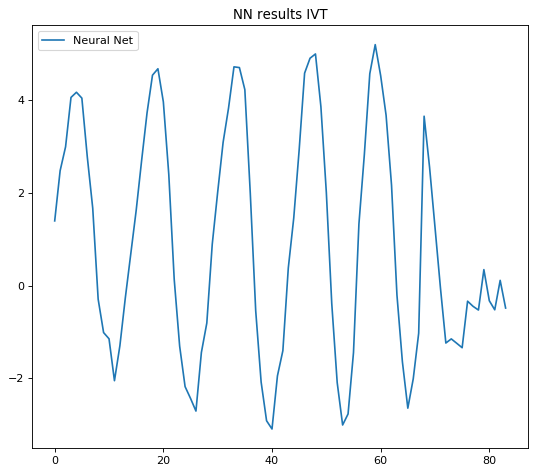

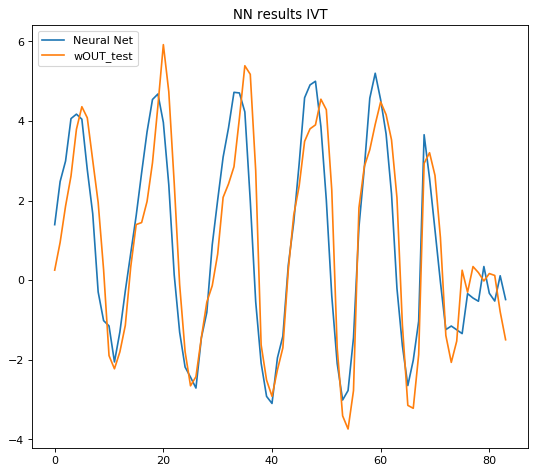

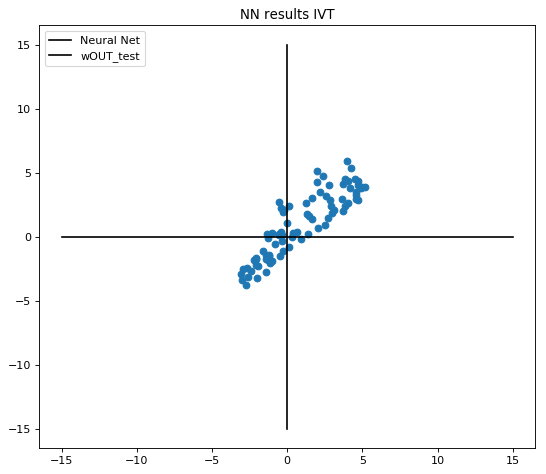

[[1.         0.88608051]
 [0.88608051 1.        ]]
Average Difference: 0.955848239156723


In [24]:
plt.figure(figsize=(8,7), dpi= 80, facecolor='w', edgecolor='k')

plot_num=700

# plt.plot(x_decoded-ivtG_test)
plt.plot(test_out[0][plot_num,:])
plt.title('NN results IVT')
plt.legend(['Neural Net'], loc='upper left')
plt.show()

plt.figure(figsize=(8,7), dpi= 80, facecolor='w', edgecolor='k')
# plt.plot(x_decoded-ivtG_test)
plt.plot(test_out[0][plot_num,:])
plt.plot(target_out[0][plot_num,:])
plt.legend(['Neural Net', 'wOUT_test'], loc='upper left')
plt.title('NN results IVT')

plt.figure(figsize=(8,7), dpi= 80, facecolor='w', edgecolor='k')
# plt.plot(x_decoded-ivtG_test)
plt.scatter(test_out[0][plot_num,:],target_out[0][plot_num,:])
plt.plot(np.array([-15,15]),np.array([0,0]),color='k')
plt.plot(np.array([0,0]),np.array([-15,15]),color='k')

plt.legend(['Neural Net', 'wOUT_test'], loc='upper left')
plt.title('NN results IVT')


plt.show()

print(np.corrcoef(test_out[0][plot_num,:], target_out[0][plot_num,:]))

print('Average Difference:',np.mean(np.sqrt((test_out[0][plot_num,:]-target_out[0][plot_num,:])**2)))


In [25]:
wOUT_test2 = target_out[0]
x_decoded2 = test_out[0]

mseN = np.sqrt(np.mean(((wOUT_test2)**1 - (x_decoded2)**1)**2))
print('Neural Net RMSE:')
print(mseN)

mIVTm = np.mean((wOUT_test2)**1)
mIVTn = np.mean((x_decoded2)**1)

print('Bias NN')
BiasNN = np.mean((wOUT_test2)**1)-np.mean((x_decoded2)**1)
print(BiasNN)

print('CRMSE NN')
CRMSEnn = np.sqrt(np.mean(((((wOUT_test2)**1)-mIVTm)-(((x_decoded2)**1)-mIVTn))**2))
print(np.sqrt(np.mean(((((wOUT_test2)**1)-mIVTm)-(((x_decoded2)**1)-mIVTn))**2)))

Neural Net RMSE:
1.703178375592553
Bias NN
0.11178419371222148
CRMSE NN
1.6995060693692572


## Do Positive Test

In [26]:
countPOScorr = 0
countNEGcorr = 0
countWRONG = 0 
countTOT = 0 

for ii in range(target_out[0].shape[0]):
    for kk in range(target_out[0].shape[1]):
        testnum = target_out[0][ii,kk]
        targnum = test_out[0][ii,kk] 

        if (targnum > 1.5) or (targnum < -1.5):
            countTOT = countTOT +1 
        
            if (testnum >= 0) and (targnum >= 0):
                countPOScorr = countPOScorr+1
        
            elif (testnum < 0) and (targnum < 0):
                countNEGcorr = countNEGcorr+1
            else: 
                countWRONG = countWRONG +1 
            
print('% correct direction:', (countNEGcorr+countPOScorr)/countTOT)
print('% incorrect direction: ', countWRONG/countTOT)
countNEGcorr+countWRONG+countPOScorr


% correct direction: 0.94385586879751
% incorrect direction:  0.056144131202489976


33414

## Load HI Mask

In [27]:
maskq = sio.loadmat('/Volumes/File_Storage/Qscat/qscat_maskq_HAW.mat')
print(maskq['maskq'].shape)
HImask = maskq['maskq']
HImask = np.transpose(HImask)

(17, 56)


## Spatial Positive test

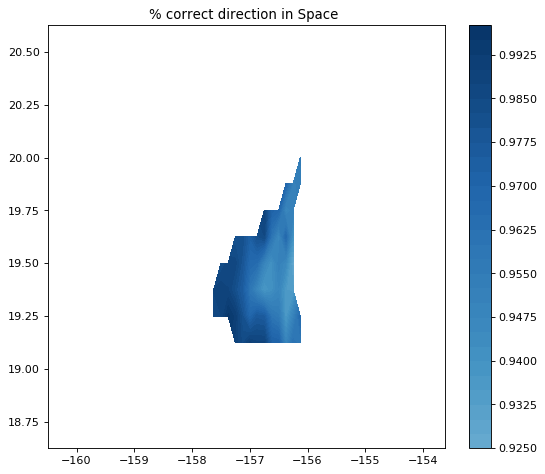

[456. 444. 425. 418. 421. 401. 355. 286. 183.  95.  82. 144. 463. 476.
 464. 465. 456. 438. 424. 401. 368. 315. 231. 157.  89. 100. 130. 482.
 491. 483. 480. 469. 458. 466. 426. 357. 322. 262. 210. 157.  99.  12.
 510. 515. 498. 466. 481. 479. 442. 384. 308. 273. 246. 177.  98.   7.
 522. 539. 515. 491. 461. 420. 346. 270. 230. 174.  59.   6. 547. 485.
 406. 295. 206. 164. 173.   6. 378. 227. 130.  71.  62. 225.  76.  88.]


In [33]:
countPOScorrsp = np.zeros(target_out[0].shape[1]) 
countNEGcorrsp = np.zeros(target_out[0].shape[1]) 
countWRONGsp = np.zeros(target_out[0].shape[1]) 
countTOTsp = np.zeros(target_out[0].shape[1]) 

for ii in range(target_out[0].shape[0]):
    for kk in range(target_out[0].shape[1]):
        
        
        testnum = target_out[0][ii,kk]
        targnum = test_out[0][ii,kk] 

        if (targnum > 2) or (targnum < -2):
            countTOTsp[kk] = countTOTsp[kk] +1 
        
            if (testnum >= 0) and (targnum >= 0):
                countPOScorrsp[kk] = countPOScorrsp[kk]+1
        
            elif (testnum < 0) and (targnum < 0):
                countNEGcorrsp[kk] = countNEGcorrsp[kk]+1
            else: 
                countWRONGsp[kk] = countWRONGsp[kk] +1 
            
countNEGcorr+countWRONG+countPOScorr

timesRight = (countNEGcorrsp+countPOScorrsp)/countTOTsp


restruct= np.empty((len(lat)*len(lon),1))
restruct[:] = np.nan
restruct[rr[:,0]] = np.expand_dims(timesRight,axis=1);
POSout_Space = np.reshape(restruct,(len(lon),len(lat)),order="F")
    
plt.figure(figsize=(8,7), dpi= 80, facecolor='w', edgecolor='k')
# plt.plot(x_decoded-ivtG_test)
plt.contourf(np.squeeze(lon),np.squeeze(lat),np.transpose(POSout_Space)*np.transpose(HImask),30,cmap=plt.cm.get_cmap('RdBu'), vmin=0.7, vmax=1)

plt.title('% correct direction in Space ')
plt.colorbar()
plt.show()


print(countTOTsp)

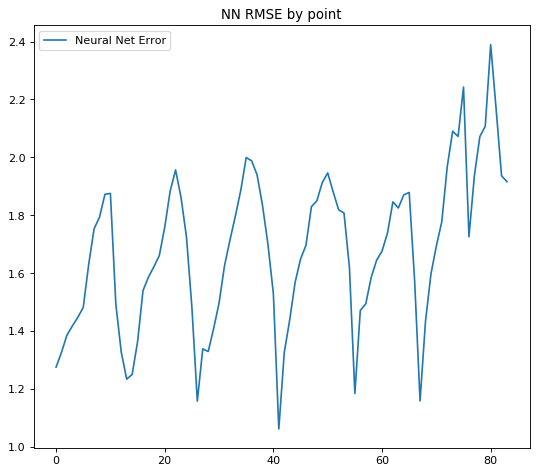

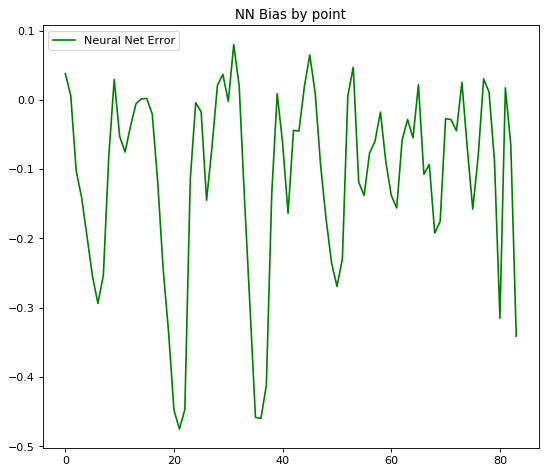

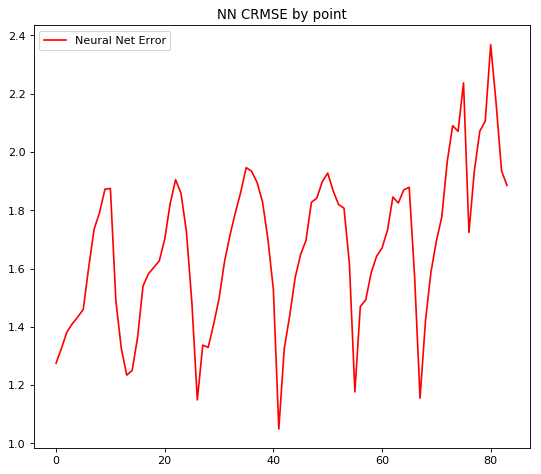

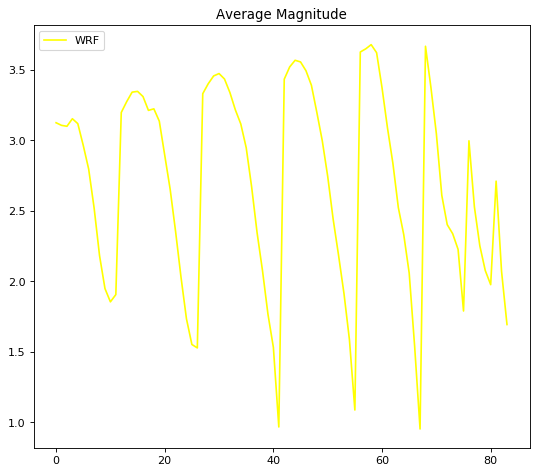

In [34]:
wOUT_test2 = target_out[0]
x_decoded2 = test_out[0]

RMSEbp = np.sqrt(np.mean(((wOUT_test2)**1 - (x_decoded2)**1)**2,axis=0))
RMSEbp.shape

MagWRF = np.mean(np.sqrt(((wOUT_test2)**2)),axis=0)

BiasBp = np.mean(x_decoded2,axis=0) - np.mean(wOUT_test2,axis=0)

mIVTmBP=np.mean((wOUT_test2)**1,axis=0)
mIVTnBP=np.mean((x_decoded2)**1,axis=0)
CRMSEnp = np.sqrt(np.mean(((((wOUT_test2)**1)-mIVTmBP)-(((x_decoded2)**1)-mIVTnBP))**2,axis=0))

plt.figure(figsize=(8,7), dpi= 80, facecolor='w', edgecolor='k')
# plt.plot(x_decoded-ivtG_test)
plt.plot(RMSEbp )
plt.title('NN RMSE by point')
plt.legend(['Neural Net Error'], loc='upper left')
plt.show()


plt.figure(figsize=(8,7), dpi= 80, facecolor='w', edgecolor='k')
# plt.plot(x_decoded-ivtG_test)
plt.plot(BiasBp, color='green')
plt.title('NN Bias by point')
plt.legend(['Neural Net Error'], loc='upper left')
plt.show()

plt.figure(figsize=(8,7), dpi= 80, facecolor='w', edgecolor='k')
# plt.plot(x_decoded-ivtG_test)
plt.plot(CRMSEnp, color='red')
plt.title('NN CRMSE by point')
plt.legend(['Neural Net Error'], loc='upper left')
plt.show()


plt.figure(figsize=(8,7), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(MagWRF, color='yellow')
plt.title('Average Magnitude')
plt.legend(['WRF'], loc='upper left')
plt.show()

In [35]:
NN_out = test_out[0]
sio.savemat('Neural_Vout.mat', {'NN_uOut':NN_out})

In [36]:
os.getcwd()

'/Volumes/File_Storage/Qscat'

## Regrid the data back to Lat/Lon

In [37]:
matfilename = All_file_names[0]
FileIN = sio.loadmat(matfilename)
mask = FileIN['hihi']
lat = FileIN['lat']
lon = FileIN['lon']

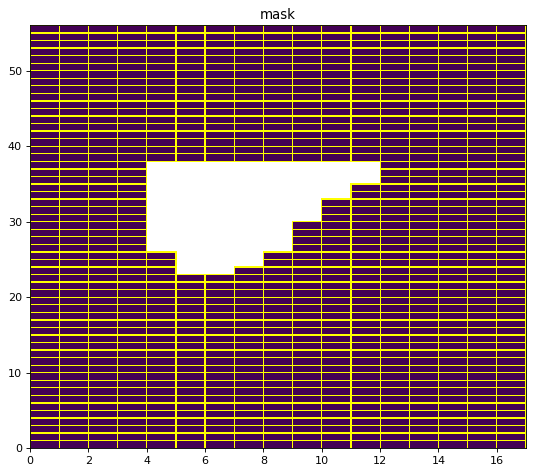

In [38]:
plt.figure(figsize=(8,7), dpi= 80, facecolor='w', edgecolor='k')
plt.pcolor(mask, color='yellow')
plt.title('mask')
plt.show()

In [39]:
mask = np.nan_to_num(mask)
mask = mask + 1;
mask[mask==2]=np.nan;
mask=np.reshape(mask,(len(lat)*len(lon),1),order="F")
rr = np.argwhere(~np.isnan(mask))

## What's it look like spatially? 
## Reconstruct both NN out and Ground Truth


In [40]:
NNout_Space = np.empty((len(lon),len(lat),test_out[0].shape[0]))
WRFout_Space = np.empty((len(lon),len(lat),test_out[0].shape[0]))
for ii in range(len(test_out[0])):
    restruct= np.empty((len(lat)*len(lon),1))
    restruct[:] = np.nan
    restruct[rr[:,0]] = np.expand_dims(test_out[0][ii,:],axis=1);
    restruct1 = np.reshape(restruct,(len(lon),len(lat)),order="F")
    
    restruct= np.empty((len(lat)*len(lon),1))
    restruct[:] = np.nan
    restruct[rr[:,0]] = np.expand_dims(target_out[0][ii,:],axis=1);
    restruct2 = np.reshape(restruct,(len(lon),len(lat)),order="F")
    
    NNout_Space[:,:,ii] = restruct1
    WRFout_Space[:,:,ii] = restruct2
    
    

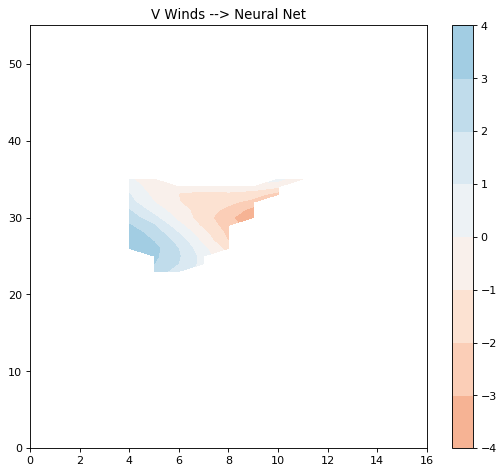

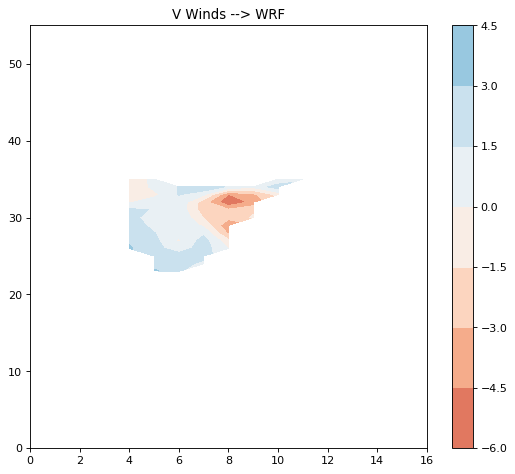

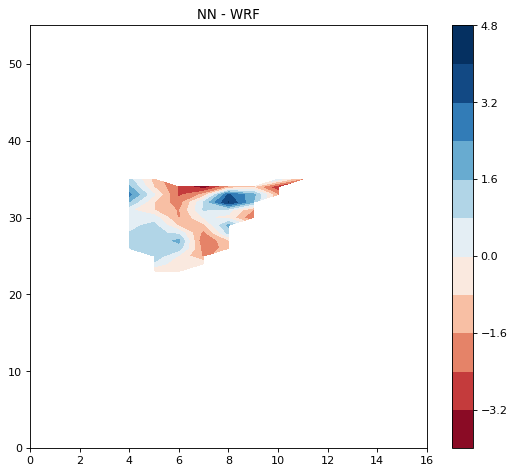

In [41]:
numplot=50
plt.figure(figsize=(8,7), dpi= 80, facecolor='w', edgecolor='k')
plt.contourf(NNout_Space[:,:,numplot]*(HImask),cmap=plt.cm.get_cmap('RdBu'), vmin=-10, vmax=10)
plt.title('V Winds --> Neural Net')
plt.colorbar()
plt.show()

restruct= np.empty((len(lat)*len(lon),1))
plt.figure(figsize=(8,7), dpi= 80, facecolor='w', edgecolor='k')
plt.contourf(WRFout_Space[:,:,numplot]*(HImask),cmap=plt.cm.get_cmap('RdBu'), vmin=-10, vmax=10)
plt.title('V Winds --> WRF')
plt.colorbar()
plt.show()

restruct= np.empty((len(lat)*len(lon),1))
plt.figure(figsize=(8,7), dpi= 80, facecolor='w', edgecolor='k')
plt.contourf(NNout_Space[:,:,numplot]*(HImask)-WRFout_Space[:,:,numplot]*(HImask),10,cmap=plt.cm.get_cmap('RdBu'), vmin=-4, vmax=4)
plt.title('NN - WRF')
plt.colorbar()
plt.show()

## Spatial Model Statistics: 

(56, 17)


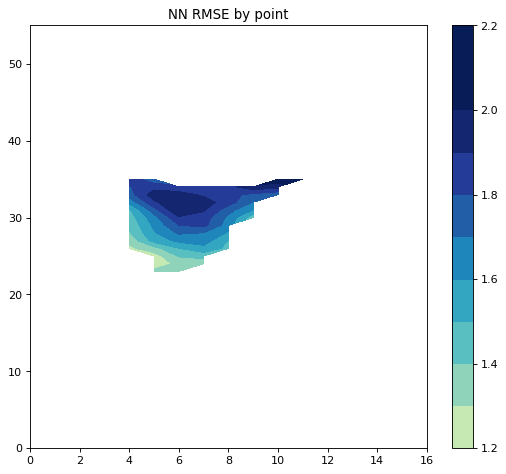

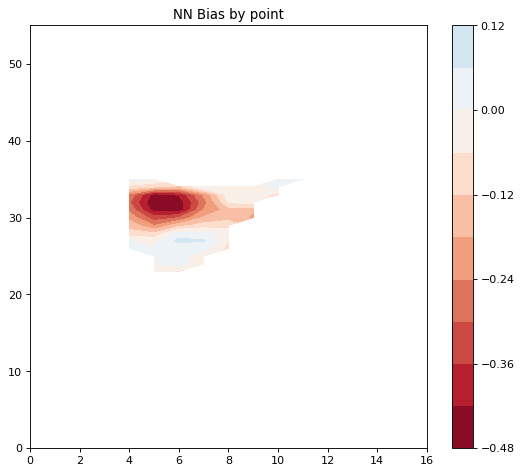

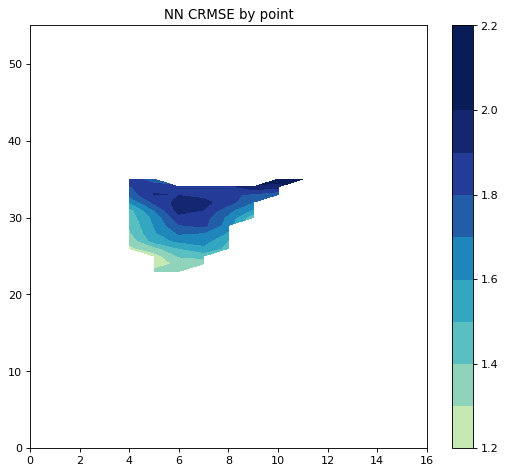

In [42]:
NNout_Space
WRFout_Space

RMSEbp = np.sqrt(np.mean(((NNout_Space) - (WRFout_Space))**2,axis=2))
BiasBp = np.mean(NNout_Space,axis=2) - np.mean(WRFout_Space,axis=2)

mIVTmBP=np.mean((WRFout_Space),axis=2)
mIVTnBP=np.mean((NNout_Space),axis=2)
CRMSEbp = np.sqrt(np.mean((((WRFout_Space)-mIVTmBP[...,None])-((NNout_Space)-mIVTnBP[...,None]))**2,axis=2))
print(CRMSEbp.shape)


plt.figure(figsize=(8,7), dpi= 80, facecolor='w', edgecolor='k')
plt.contourf(RMSEbp*(HImask),10,cmap=plt.cm.get_cmap('YlGnBu'), vmin=1, vmax=2)
plt.colorbar()
plt.title('NN RMSE by point')
plt.show()

plt.figure(figsize=(8,7), dpi= 80, facecolor='w', edgecolor='k')
plt.contourf(BiasBp*(HImask),10,cmap=plt.cm.get_cmap('RdBu'), vmin=-.5, vmax=.5)
plt.title('NN Bias by point')
plt.colorbar()
plt.show()

plt.figure(figsize=(8,7), dpi= 80, facecolor='w', edgecolor='k')
# plt.plot(x_decoded-ivtG_test)
plt.contourf(CRMSEbp*(HImask),10,cmap=plt.cm.get_cmap('YlGnBu'), vmin=1, vmax=2)
plt.title('NN CRMSE by point')
plt.colorbar()
plt.show()


## Prep the Qscat data

In [43]:
matfilename = '/Volumes/File_Storage/Qscat/data/Qscat_test/QscatTest_DL.mat'
FileIN = utils.read_Qscat_file(matfilename)
preds_test = FileIN['predictor_matrix']
preds_names_test = FileIN['predictor_names']

print(np.amax(preds_mat))
print(preds_names)
print(preds_mat.shape)
print(targ_mat.shape)
print(targ_names)

preds_Qtest = utils.MinMax_norm(preds_test,preds_names_test,1,0,MinMax_Allpreds)

17.413617029774134
['u10_hourly', 'v10_hourly']
(2208, 56, 17, 2)
(2208, 84)
v10_hourly_out


In [44]:
test_Qout = utils.apply_cnn(cnn_model_object,preds_Qtest[0])

Applying model to examples 0-39 of 72...
Applying model to examples 40-71 of 72...


In [45]:
test_Qout = utils.rescale_MinMax_norm_targ(test_Qout,targ_names,1,0,MinMax_Alltargs)
print(test_Qout)
test_Qout =test_Qout[0];

(array([[ 1.1678505 ,  1.1459503 ,  1.0002918 , ..., -0.03829575,
         0.9423542 , -0.48317528],
       [-3.9264412 , -3.1768417 , -2.315918  , ..., -2.6009655 ,
         0.24850273, -0.9686699 ],
       [ 2.1749725 ,  2.0024834 ,  1.6592197 , ...,  0.2789688 ,
         0.9610176 , -0.33405685],
       ...,
       [ 1.4442234 ,  1.7879295 ,  2.2073193 , ..., -0.08905029,
         0.24263382, -0.25112534],
       [ 1.8336678 ,  1.8891125 ,  2.0727062 , ...,  1.9618626 ,
         1.1854992 ,  0.14237785],
       [-1.393549  , -2.409052  , -2.2361488 , ..., -5.6957293 ,
        -1.7610035 , -2.7286873 ]], dtype=float32), {'v10_hourly_out': array([ 17.41361703, -21.44091812])})


## Reconstruct it in space

In [46]:
Qout_Space = np.empty((len(lon),len(lat),test_Qout[0].shape[0]))

for ii in range(len(test_Qout)):
    restruct= np.empty((len(lat)*len(lon),1))
    restruct[:] = np.nan
    restruct[rr[:,0]] = np.expand_dims(test_Qout[ii,:],axis=1);
    restruct1 = np.reshape(restruct,(len(lon),len(lat)),order="F")
    
    Qout_Space[:,:,ii] = restruct1
    
    
    

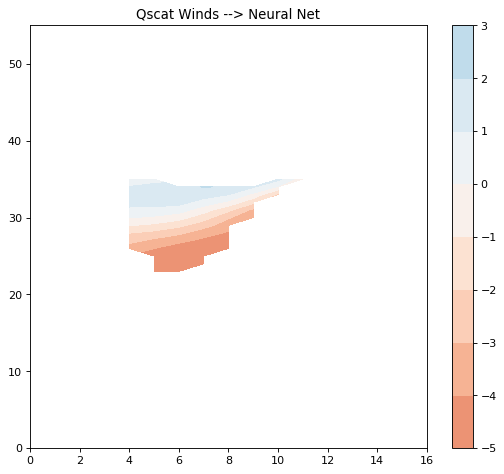

In [47]:
numplot=60
plt.figure(figsize=(8,7), dpi= 80, facecolor='w', edgecolor='k')
plt.contourf(Qout_Space[:,:,numplot]*(HImask),cmap=plt.cm.get_cmap('RdBu'), vmin=-10, vmax=10)
plt.title('Qscat Winds --> Neural Net')
plt.colorbar()
plt.show()

In [48]:
preds_Qout = utils.rescale_MinMax_norm(preds_Qtest[0],preds_names,1,0,MinMax_Allpreds)


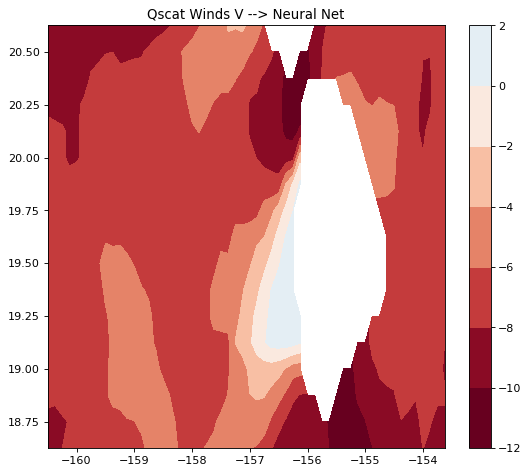

In [50]:
numplot=1

#predictor
preds_Qout[0].shape
addback = np.squeeze(preds_Qout[0][numplot,:,:,0])

#target
Qtargout = np.squeeze(Qout_Space[:,:,numplot])

where_are_NaNs = np.isnan(Qtargout)
Qtargout[where_are_NaNs] = 0

plottit =np.transpose(Qtargout+addback)
plottit[plottit==0]=np.nan

plt.figure(figsize=(8,7), dpi= 80, facecolor='w', edgecolor='k')
plt.contourf(np.squeeze(lon),np.squeeze(lat),plottit*np.transpose(HImask),cmap=plt.cm.get_cmap('RdBu'), vmin=-10, vmax=10)
plt.title('Qscat Winds V --> Neural Net')
plt.colorbar()
plt.show()

## Load in Qscat 

In [51]:
matfilename = '/Volumes/File_Storage/Qscat/data/Qscat_test/QscatTest_DL.mat'
Qscat=sio.loadmat(matfilename)
Qscat_old = Qscat['vq_old']
aq  =  Qscat['avq']

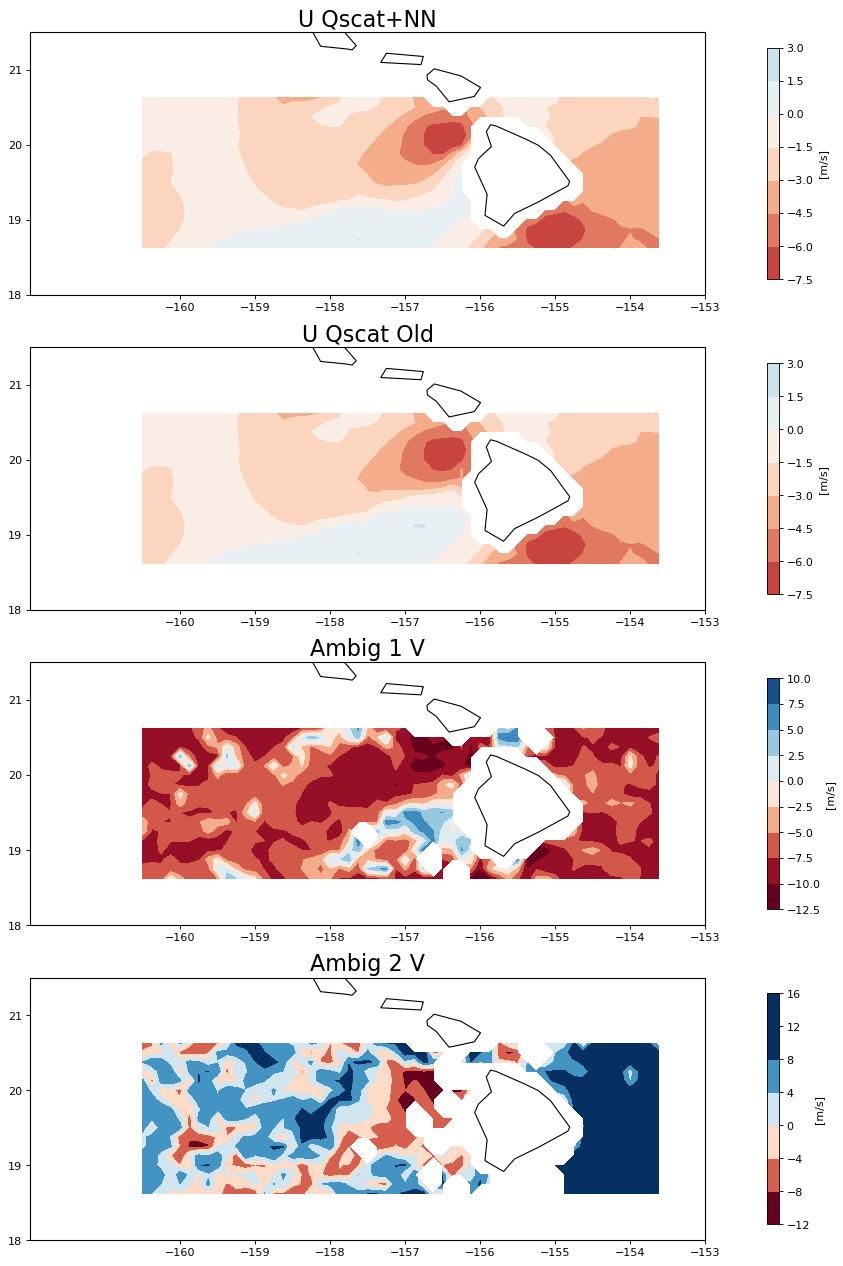

In [59]:
numplot=4


#### reconstructed Qscat #################
#predictor
preds_Qout[0].shape
addback = np.squeeze(preds_Qout[0][numplot,:,:,1])

#target
Qtargout = np.squeeze(Qout_Space[:,:,numplot])

where_are_NaNs = np.isnan(Qtargout)
where_are_NaNs = copy.deepcopy(where_are_NaNs)

Qtargout[where_are_NaNs] = 0

plottit =np.transpose(Qtargout+addback)
plottit[plottit==0]=np.nan
########################################


#### OLD Qscat ###########################
Qscat_old = Qscat['vq_old']
p_old = Qscat_old[:,:,numplot]
p_old = np.transpose(p_old)
p_old[np.isnan(plottit)] = np.nan

########################################


#### Ambiguity1 Qscat ###################
aq_1 = copy.deepcopy(aq[:,:,0,numplot])

aq_1[where_are_NaNs] = np.nan
aq_1 = np.transpose(aq_1)
########################################

#### Ambiguity2 Qscat ###################
aq_2 = aq[:,:,1,numplot]

aq_2[where_are_NaNs] = np.nan
aq_2 = np.transpose(aq_2)
########################################

########################################
########################################
##########    Figures   ################
########################################
########################################


plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')

proj = ccrs.PlateCarree()
ax = plt.subplot(4, 1, 1,projection = proj)
ax.add_feature(cf.BORDERS)

ax.set_xticks(np.linspace(-160,-150, 11), crs=proj)
ax.set_yticks(np.linspace(18, 24, 7), crs=proj)

ax.add_feature(cf.NaturalEarthFeature(
               category='cultural',
               name='admin_1_states_provinces_lines',
               scale='50m',
               facecolor='none'))

ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.set_extent([-162, -153, 18, 21.5])


plt.contourf(np.squeeze(lon),np.squeeze(lat),plottit*np.transpose(HImask),cmap=plt.cm.get_cmap('RdBu'), vmin=-10, vmax=10)
cbar = plt.colorbar(ax = ax, shrink=0.88)
cbar.set_label('[m/s]',fontsize=10)
plt.title('V Qscat+NN',fontsize=20)


########################################


proj = ccrs.PlateCarree()
ax.add_feature(cf.BORDERS)
ax = plt.subplot(4, 1, 2,projection = proj)

ax.set_xticks(np.linspace(-160,-150, 11), crs=proj)
ax.set_yticks(np.linspace(18, 24, 7), crs=proj)

ax.add_feature(cf.NaturalEarthFeature(
               category='cultural',
               name='admin_1_states_provinces_lines',
               scale='50m',
               facecolor='none'))

ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.set_extent([-162, -153, 18, 21.5])


plt.contourf(np.squeeze(lon),np.squeeze(lat),p_old*np.transpose(HImask),cmap=plt.cm.get_cmap('RdBu'), vmin=-10, vmax=10)
cbar = plt.colorbar(ax = ax, shrink=0.88)
cbar.set_label('[m/s]',fontsize=10)
plt.title('V Qscat Old',fontsize=20)


########################################

proj = ccrs.PlateCarree()
ax.add_feature(cf.BORDERS)
ax = plt.subplot(4, 1, 3,projection = proj)

ax.set_xticks(np.linspace(-160,-150, 11), crs=proj)
ax.set_yticks(np.linspace(18, 24, 7), crs=proj)

ax.add_feature(cf.NaturalEarthFeature(
               category='cultural',
               name='admin_1_states_provinces_lines',
               scale='50m',
               facecolor='none'))

ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.set_extent([-162, -153, 18, 21.5])


plt.contourf(np.squeeze(lon),np.squeeze(lat),aq_1*np.transpose(HImask),cmap=plt.cm.get_cmap('RdBu'), vmin=-10, vmax=10)
cbar = plt.colorbar(ax = ax, shrink=0.88)
cbar.set_label('[m/s]',fontsize=10)
plt.title('Ambig 1 V',fontsize=20)


########################################

proj = ccrs.PlateCarree()
ax.add_feature(cf.BORDERS)
ax = plt.subplot(4, 1, 4,projection = proj)

ax.set_xticks(np.linspace(-160,-150, 11), crs=proj)
ax.set_yticks(np.linspace(18, 24, 7), crs=proj)

ax.add_feature(cf.NaturalEarthFeature(
               category='cultural',
               name='admin_1_states_provinces_lines',
               scale='50m',
               facecolor='none'))

ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.set_extent([-162, -153, 18, 21.5])


plt.contourf(np.squeeze(lon),np.squeeze(lat),aq_2*np.transpose(HImask),cmap=plt.cm.get_cmap('RdBu'), vmin=-10, vmax=10)
cbar = plt.colorbar(ax = ax, shrink=0.88)
cbar.set_label('[m/s]',fontsize=10)
plt.title('Ambig 2 V',fontsize=20)

V_Q1= p_old
V_N1= plottit
a_q = copy.deepcopy(aq[:,:,:,numplot])



## make a seasonal composite: 

In [56]:
season_nn = np.zeros([preds_Qout[0].shape[0],preds_Qout[0].shape[1],preds_Qout[0].shape[2]])
season_qs = np.zeros([preds_Qout[0].shape[0],preds_Qout[0].shape[1],preds_Qout[0].shape[2]])


for ii in range(preds_Qout[0].shape[1]):
    numplot=ii


    #### reconstructed Qscat #################
    #predictor
    preds_Qout[0].shape
    addback = np.squeeze(preds_Qout[0][numplot,:,:,1])

    #target
    Qtargout = np.squeeze(Qout_Space[:,:,numplot])

    where_are_NaNs = np.isnan(Qtargout)
    where_are_NaNs = copy.deepcopy(where_are_NaNs)

    Qtargout[where_are_NaNs] = 0

    plottit =(Qtargout+addback)
    plottit[plottit==0]=np.nan
    
    season_nn[ii,:,:] = plottit
    ########################################
    
    #### OLD Qscat ###########################
    Qscat_old = Qscat['vq_old']
    p_old = Qscat_old[:,:,numplot]
    p_old = (p_old)
    p_old[np.isnan(plottit)] = np.nan
    
    season_qs[ii,:,:] = p_old
    ########################################



Text(0.5, 1.0, 'Composite V Qscat Old - Season')

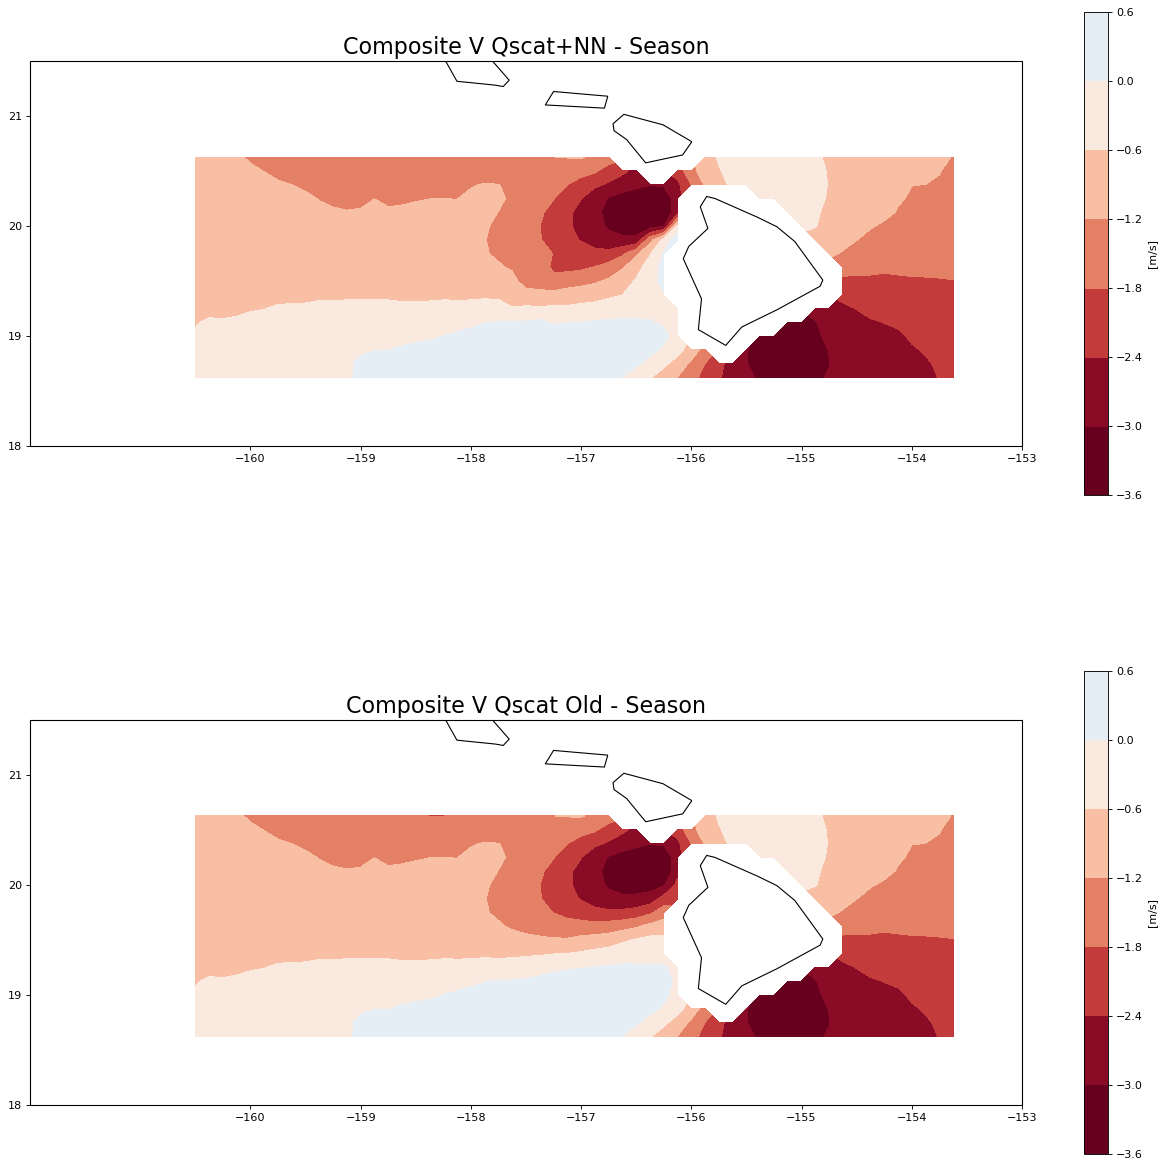

In [57]:
########################################
########################################
##########   Composite Figures   ################
########################################
########################################


plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')

proj = ccrs.PlateCarree()
ax = plt.subplot(2, 1, 1,projection = proj)
ax.add_feature(cf.BORDERS)

ax.set_xticks(np.linspace(-160,-150, 11), crs=proj)
ax.set_yticks(np.linspace(18, 24, 7), crs=proj)

ax.add_feature(cf.NaturalEarthFeature(
               category='cultural',
               name='admin_1_states_provinces_lines',
               scale='50m',
               facecolor='none'))

ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.set_extent([-162, -153, 18, 21.5])

seasonN = np.transpose(np.nanmean(season_nn,axis=0))
plt.contourf(np.squeeze(lon),np.squeeze(lat),seasonN*np.transpose(HImask),cmap=plt.cm.get_cmap('RdBu'), vmin=-3, vmax=3)
cbar = plt.colorbar(ax = ax, shrink=0.88)
cbar.set_label('[m/s]',fontsize=10)
plt.title('Composite V Qscat+NN - Season',fontsize=20)


########################################


proj = ccrs.PlateCarree()
ax.add_feature(cf.BORDERS)
ax = plt.subplot(2, 1, 2,projection = proj)

ax.set_xticks(np.linspace(-160,-150, 11), crs=proj)
ax.set_yticks(np.linspace(18, 24, 7), crs=proj)

ax.add_feature(cf.NaturalEarthFeature(
               category='cultural',
               name='admin_1_states_provinces_lines',
               scale='50m',
               facecolor='none'))

ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.set_extent([-162, -153, 18, 21.5])


seasonQ = np.transpose(np.nanmean(season_qs,axis=0))
plt.contourf(np.squeeze(lon),np.squeeze(lat),seasonQ*np.transpose(HImask),cmap=plt.cm.get_cmap('RdBu'), vmin=-3, vmax=3)
cbar = plt.colorbar(ax = ax, shrink=0.88)
cbar.set_label('[m/s]',fontsize=10)
plt.title('Composite V Qscat Old - Season',fontsize=20)


########################################

In [60]:
HImask3 = np.expand_dims(HImask,axis=2)


sio.savemat('Vdata.mat', {
        'lat': lat,
        'lon': lon,
        'VSeasonN': seasonN*np.transpose(HImask),
        'VSeasonQ': seasonQ*np.transpose(HImask),
        'V_Q1': V_Q1*np.transpose(HImask),
        'V_N1': V_N1*np.transpose(HImask),
        'a_vq': a_q*HImask3
        
    }) 

## Load the Ambiguities
and work on selection of closest analogs. 

In [306]:
test_Qout[0,:]

array([ 1.1678505 ,  1.1459503 ,  1.0002918 ,  0.9170284 ,  0.63306046,
        0.47039986,  0.1708126 , -0.07771111, -0.45276642, -0.72501373,
       -1.1784344 , -1.8825169 ,  0.16860771,  0.4310875 ,  0.4996109 ,
        0.52108   ,  0.41936874,  0.2994442 ,  0.16877747, -0.02210045,
       -0.21012688, -0.45122337, -0.5588379 , -0.6891327 , -0.7964554 ,
       -1.0989838 , -1.5543709 , -0.43815613, -0.4054966 , -0.45528793,
       -0.5162926 , -0.48082542, -0.5483017 , -0.6184864 , -0.57177734,
       -0.7620926 , -0.72730637, -0.6713505 , -0.42458153, -0.45249557,
       -0.6106262 , -0.40181923, -1.3254395 , -1.3660603 , -1.5195599 ,
       -1.4136429 , -1.3105774 , -1.3592377 , -1.2022953 , -0.84729385,
       -0.6772213 , -0.47382545, -0.02906799,  0.10432625, -0.274683  ,
        0.2249527 , -2.2998123 , -2.3680477 , -2.2809238 , -2.1544285 ,
       -1.7796307 , -1.376482  , -0.9600105 , -0.3967495 ,  0.02584267,
        0.5461273 ,  0.55129814,  0.11398506, -2.811081  , -2.29

In [311]:
matfilename = '/Volumes/File_Storage/Qscat/data/Qscat_test/QscatTest_DL.mat'


In [312]:
Qscat=sio.loadmat(matfilename)

In [318]:
av = Qscat['avq'] #v-ambiguities 

In [319]:
av.shape

(56, 17, 4, 72)

In [322]:
av_flat = np.reshape(av,(len(lon)*len(lat),av.shape[2],av.shape[3]),order="F")

In [323]:
av_flat.shape

(952, 4, 72)

In [ ]:
batch_num=40
num_batches_per_ep = int(np.floor(targ_mat.shape[0]/batch_num))
print(num_batches_per_ep)


## Explore data

Before you train a model, you need to understand the data that you are using to train it.  

You have to load and scale your data. make sure everything is how you expect it and the split your data into training and testing datasets. 

### Access your DataSet 

### Display some sample images

Load the compressed files into `numpy` arrays. Then use `matplotlib` to plot random images from the dataset. Note this step requires a `load_data` function that's included in an `util.py` file. This file is included in the sample folder. Please make sure it is placed in the same folder as this notebook. The `load_data` function simply parses the compresse files into numpy arrays.

### We are going to be using GFS 120 hour  Integrated Vapor Transport [ivt], uivt and vivt data to predict the MERRA2 IVT field. 
Lat / Lon is near Bodega Bay California where there is an atmospheric river observation station. Shown as the wind and rain symbol. 


<img src="California_IVT.png" alt="drawing" width="400"/>



## The network we will build is a MultiLayer Perceptron as shown below: 
<img src="MLP.png" alt="drawing" width="400"/>


## Dates First
I split this file and kept the dates elsewhere because this is a little test case

## Load & Prep Data Here 

Also we need to split data into TESTING VALIDATION and TRAINING data (which is split from the original full dataset, see schematic below). This is what we need to prove that our model is doing well, we evaluate our data on a testing set that the network has never seen before. 

![alt text](Train_Test_Split.png "Title")

reference
https://medium.com/datadriveninvestor/data-science-essentials-why-train-validation-test-data-b7f7d472dc1f

In [7]:
matfilename = '/Volumes/File_Storage/Qscat/data/uv10_hourly_v24hr_1990_.mat'

data = sio.loadmat('/Volumes/File_Storage/Qscat/InOut.mat')
wIN = data['inputU']
wOUT = data['outputU']
MAT_Uin = 'inputU'
hey = np.array(data[MAT_Uin][:],dtype=float)

In [8]:
hey.shape

(11470, 6992)

In [3]:
print(wOUT.shape)
print(wIN.shape)

(1783, 6992)
(11470, 6992)


In [4]:
data = sio.loadmat('/Volumes/File_Storage/Qscat/InOut.mat')
wIN = data['inputU'].T
wOUT = data['outputU'].T

## clean days with NANS 
indsG = np.argwhere(np.isnan(wIN))
indsG = indsG.astype(int)
indsG = indsG[:,0]

indsM = np.argwhere(np.isnan(wOUT))
indsM = indsM.astype(int)
indsM = indsM[:,0]

indsA = np.append(indsM,indsG)
print('deleting these indices')
print(indsA)


wIN = np.delete(wIN,indsA,axis=1)
wOUT = np.delete(wOUT,indsA,axis=1)


# ## delete the forecast times also. 
# timesFCST = np.delete(timesFCST,indsA,axis=0)
# ##

print(wIN.shape)
print(wOUT.shape)


# deep learning algorithms prefer if your data is scaled between [0,1]--- so do that. 
#scale ivt uivt vivt etc. 

#split test/train 

wOUT_train = wOUT[0:6500,:]
wIN_train = wIN[0:6500,:]

print('LOOK HERE:::')
print(wOUT_train.shape)

wOUT_test = wOUT[6500:,:]
wIN_test = wIN[6500:,:]
print(wIN_test.shape)
print(wOUT_test.shape)

deleting these indices
[]
(6992, 11470)
(6992, 1783)
LOOK HERE:::
(6500, 1783)
(492, 11470)
(492, 1783)


In [5]:
train_data = np.concatenate((wOUT_train,wIN_train),axis=1)

wOUT_test = wOUT[6500:,:]
wIN_test = wIN[6500:,:]

test_data = np.concatenate((wOUT_test,wIN_test),axis=1)
print('LOOK HERE:::')
print(train_data.shape)
print(test_data.shape)

LOOK HERE:::
(6500, 13253)
(492, 13253)


## Scale your data: 

In [8]:
def min_max_scale(X, range=(0, 1)):
    mi, ma = range
    Xmin = X.min()
    Xmax = X.max()
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (ma - mi) + mi
    return X_scaled, Xmin, Xmax 

[norm_train, Xmin, Xmax]= min_max_scale(train_data)
norm_test = (test_data-Xmin)/(Xmax-Xmin)
norm_test = norm_test * (1-0)+0

print(norm_train.shape)
norm_train = shuffle(norm_train)
print(norm_train.shape)
rescaled = (norm_test*(Xmax-Xmin))+Xmin

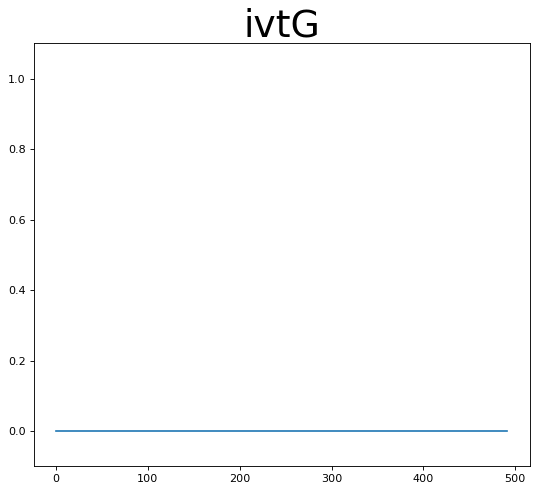

0.21823417269241413


In [9]:
plt.figure(figsize=(8,7), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(rescaled[:,0]-test_data[:,0])
plt.title('ivtG',fontsize=34)
plt.ylim(-.1, 1.1)   
plt.show()
print(np.min(norm_train[:,1]))

## Visualize Scaled Features To Make sure Nothing Funky is going on

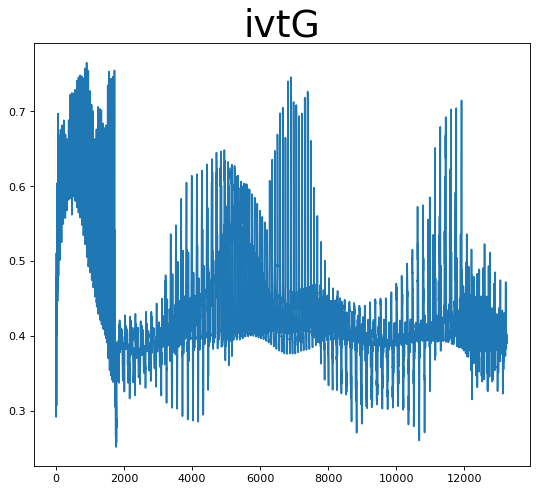

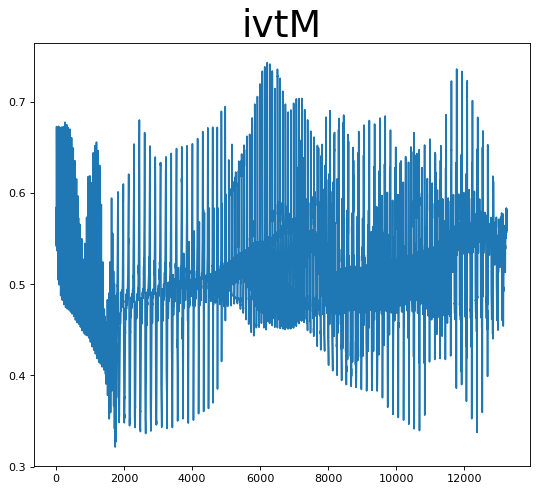

In [10]:
plt.figure(figsize=(8,7), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(norm_test[1,:])
plt.title('ivtG',fontsize=34)
plt.show()

plt.figure(figsize=(8,7), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(norm_train[1,:])
plt.title('ivtM',fontsize=34)
plt.show()

## Set Some Parameters for this Space

## NOW WE WILL BUILD OUR KERAS MODEL

this can be done by using the functional API, the context is given below. It is very straight forward to add layers. 

In [38]:
## Build the Keras Layers: 
batch_size = 60

visible = Input(shape=(wIN_test.shape[1],))      # input 
hidden1 = Dense(40, activation='relu',name='Hidden1')(visible) #hidden 1 
hidden2 = Dense(30, activation='relu',name='Hidden2')(hidden1) #hidden 2 
hidden2 = BatchNormalization(name='Batch_Norm_1')(hidden2)     #Normalize 1 
hidden3 = Dense(30, activation='relu',name='Hidden3')(hidden2) #Normalize 1 
hidden3 = BatchNormalization(name='Batch_Norm_2')(hidden3)     #hidden 3
hidden3 = Dropout(0.2)(hidden3)
hiddenX = Dense(50, activation='relu',name='Hidden_4')(hidden3)#hidden 4
hiddenX = BatchNormalization(name='Batch_Norm_3')(hiddenX)     #hidden 3
output = Dense(wOUT_train.shape[1], activation='linear',name='output')(hiddenX) #output 
model = Model(inputs=visible, outputs=output)

## Print the multilayer perception 

plot_model(model, to_file='multilayer_perceptron_graph.png')
adm = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adm, loss='mse',metrics=['mse'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 11470)             0         
_________________________________________________________________
Hidden1 (Dense)              (None, 40)                458840    
_________________________________________________________________
Hidden2 (Dense)              (None, 30)                1230      
_________________________________________________________________
Batch_Norm_1 (BatchNormaliza (None, 30)                120       
_________________________________________________________________
Hidden3 (Dense)              (None, 30)                930       
_________________________________________________________________
Batch_Norm_2 (BatchNormaliza (None, 30)                120       
_________________________________________________________________
dropout_5 (Dropout)          (None, 30)                0         
__________

In [39]:
norm_train[:,0:11470].shape

(6500, 11470)

## What does our network look like? 

<img src="multilayer_perceptron_graph.png" alt="drawing" width="200"/>

 
## Now We Train the Model by "Fitting it"

We will use an ADAM optimizer.... which is a little complicated to explain but is essentially a stochastic gradient descent method. 

## We are using Mean Squared Error (between IVT_gfs vs. IVT_merra) as Cost. 

y = (ivt_gfs - ivt_merra)^2

### What does our cost function field look like? Can we optimize? Is there skill to find? 

I think this is a fun visualization of three potential gradient fields (using 2 [x,y] parameters, cost is in the [z] direction). (Plot a) is the best case scenario. If there is no gradient to find (plot b) then it's impossible to train a network. If it's a chaotic mess (plot c), again there is not optimal solution. 

<img src="costFunction.png" alt="drawing" width="700"/>


In [40]:
reduce_lr = ReduceLROnPlateau(monitor='val_mean_squared_error', factor=0.8,
                              patience=13, min_lr=0.0000005,verbose=1)

history = model.fit(norm_train[:,0:11470],norm_train[:,11470:],validation_split=0.05,
                    epochs=40,callbacks=[reduce_lr],verbose=2)

Train on 6175 samples, validate on 325 samples
Epoch 1/40
 - 5s - loss: 0.0781 - mean_squared_error: 0.0781 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 2/40
 - 4s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 3/40
 - 4s - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 4/40
 - 4s - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 5/40
 - 4s - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 6/40
 - 5s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0136 - val_mean_squared_error: 0.0136
Epoch 7/40
 - 4s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 8/40
 - 4s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 9/40
 - 4s - loss: 0.0015 - mean_squared_er

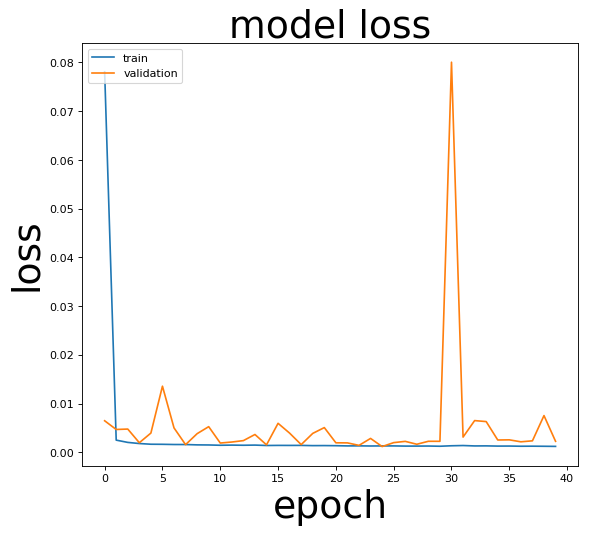

In [41]:
# summarize history for loss
plt.figure(figsize=(8,7), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss',fontsize=34)
plt.ylabel('loss',fontsize=34)
plt.xlabel('epoch',fontsize=34)
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

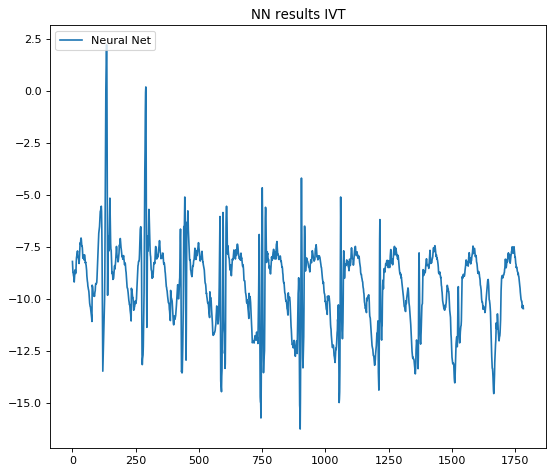

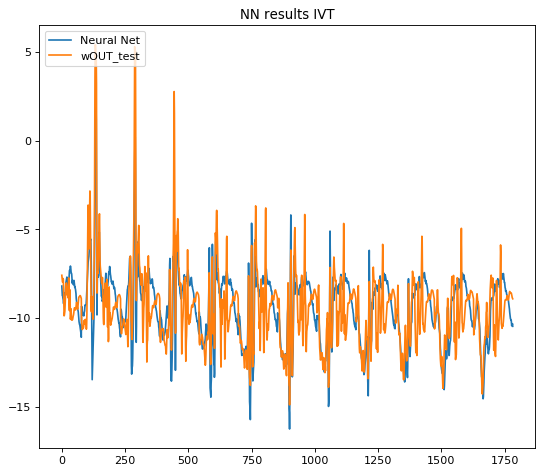

In [48]:
x_decoded = model.predict(norm_test[:,0:11470])
x_decoded_tr = model.predict(norm_train[:,0:11470])

plt.figure(figsize=(8,7), dpi= 80, facecolor='w', edgecolor='k')

# plt.plot(x_decoded-ivtG_test)
plt.plot((x_decoded[9,:]*(Xmax-Xmin))+Xmin)
plt.title('NN results IVT')
plt.legend(['Neural Net'], loc='upper left')
plt.show()

plt.figure(figsize=(8,7), dpi= 80, facecolor='w', edgecolor='k')
# plt.plot(x_decoded-ivtG_test)
plt.plot((x_decoded[9,:]*(Xmax-Xmin))+Xmin)
plt.plot((norm_test[9,11470:]*(Xmax-Xmin))+Xmin)
plt.legend(['Neural Net', 'wOUT_test'], loc='upper left')
plt.title('NN results IVT')
plt.show()

# plt.figure(figsize=(8,7), dpi= 80, facecolor='w', edgecolor='k')
# plt.plot(x_decoded-ivtG_test)
# plt.title('NN results IVT')
# plt.legend(['Neural Net - ivtG'], loc='upper left')
# plt.show()


# # plt.plot(x_decoded-ivtG_test)
# plt.figure(figsize=(8,7), dpi= 80, facecolor='w', edgecolor='k')
# plt.plot(x_decoded_tr)
# plt.plot(ivtM_train)
# plt.plot(ivtG_train)
# plt.legend(['Neural Net', 'ivtM_test','ivtG_test'], loc='upper left')
# plt.title('NN results IVT')
# plt.show()


In [44]:
wOUT_test2 = (norm_test[:,11470:]*(Xmax-Xmin))+Xmin
x_decoded2 = (x_decoded*(Xmax-Xmin))+Xmin

mseN = np.sqrt(np.mean(((wOUT_test2)**1 - (x_decoded2)**1)**2))
print('Neural Net RMSE:')
print(mseN)

mIVTm = np.mean((wOUT_test2)**1)
mIVTn = np.mean((x_decoded2)**1)

print('Bias NN')
BiasNN = np.mean((wOUT_test2)**1)-np.mean((x_decoded2)**1)
print(BiasNN)

print('CRMSE NN')
CRMSEnn = np.sqrt(np.mean(((((wOUT_test2)**1)-mIVTm)-(((x_decoded2)**1)-mIVTn))**2))
print(np.sqrt(np.mean(((((wOUT_test2)**1)-mIVTm)-(((x_decoded2)**1)-mIVTn))**2)))

Neural Net RMSE:
2.2079363609310696
Bias NN
0.3206556612556213
CRMSE NN
2.184528102776673


<IPython.core.display.Javascript object>


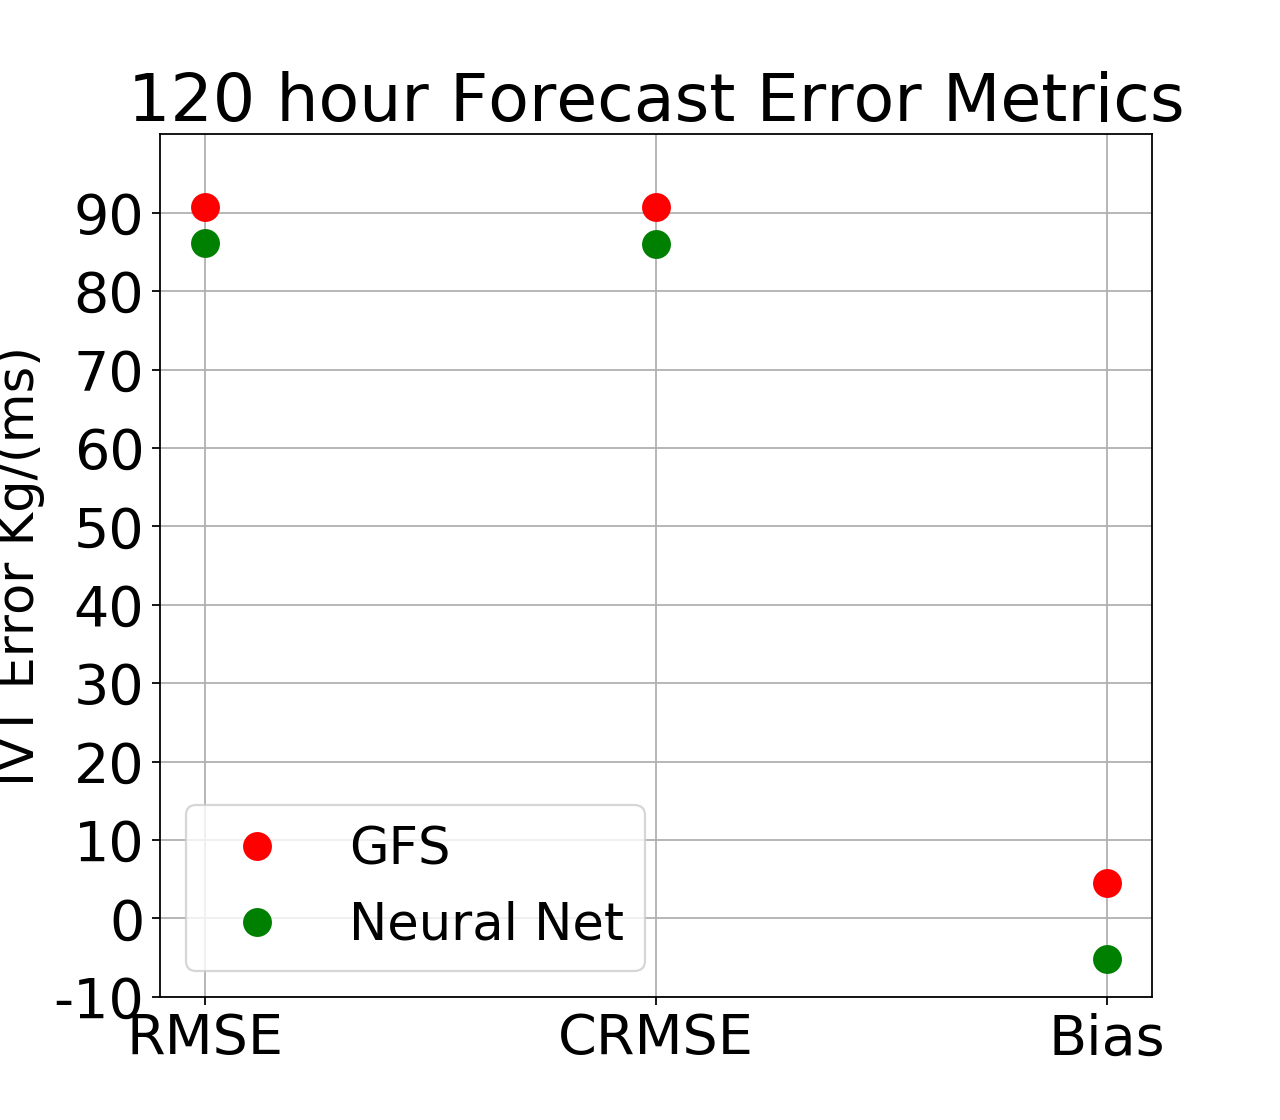

In [123]:
GFSval = np.append(mseG,CRMSEgfs)
GFSval = np.append(GFSval,BiasGfs)

NNval = np.append(mseN,CRMSEnn)
NNval = np.append(NNval,BiasNN)

fig = plt.figure(figsize=(8,7), dpi= 80, facecolor='w', edgecolor='k')

x = [0,1,2]
plt.plot(x,GFSval, 'ro', markersize=12)
plt.plot(x,NNval, 'go', markersize=12)
my_xticks = ['RMSE','CRMSE','Bias']
plt.xticks(x, my_xticks)
ax = fig.gca()
my_yticks = np.arange(-10, 100, 10);
ax.set_yticks(my_yticks)
plt.title('120 hour Forecast Error Metrics',fontsize=30)
plt.legend(['GFS','Neural Net'],fontsize=23)
plt.ylabel('IVT Error Kg/(ms)',fontsize=23)
ax.set_xticklabels(my_xticks, rotation=0, fontsize=25)
ax.set_yticklabels(my_yticks, rotation=0, fontsize=25)
plt.ylim((-10,100))
plt.grid()
plt.show()